# Задание по байесовской линейной регрессии

__Предупреждение про списывание.__ Строго запрещается использовать код или решения задач других студентов в своем решении. Код из открытых источников разрешается брать только фрагментами по одной строке (например, скопировать пример использования какой-то функции), нельзя копировать код по несколько строк. В случае обнаружения похожих решений выставляется 0 за __все__ задание __обоим__ студентам, чьи работы являются похожими, и подается служебная записка в деканат.

## Теоретическая часть
Напишите решения задач либо здесь ниже в ноутбуке, используя TeX для написания формул, либо оформите на листочке и загрузите __одним__ pdf файлом (проверять несколько отдельных фотографий очень неудобно).

1. __(1 балл)__ Дана выборка независимых одинаково распределенных случайных величин $X=\{x_1, \dots, x_N\}$, $x_i \in \mathbb{R}$, 
$$p(x_i~|~\mu_0, \tau) = \mathcal{N}(x~|~\mu_0, \tau^{-1})=\frac{\sqrt{\tau}}{\sqrt{2\pi}}\exp\bigl(-\frac \tau 2 (x-\mu_0)^2\bigr),$$
значение $\mu_0$ известно, а значение $\tau$ требуется оценить, используя байесовский подход. Априорное распределение на $\tau$ - [Гамма-распределение](https://ru.wikipedia.org/wiki/%D0%93%D0%B0%D0%BC%D0%BC%D0%B0-%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5):
$$p(\tau~|~k_0, \theta_0) = \frac 1 {\Gamma(k_0) \theta_0^{k_0}} \tau^{k_0-1} exp\bigl(-\frac \tau {\theta_0}\bigr),$$
значения $\theta_0$ и $k_0$ фиксированы. __Найдите апостериорное распределение__ $p(\tau|X)$ (все зафиксированные величины $*_0$ после черты опущены для сокращения обозначений, вы тоже можете так делать при желании). 
2. __(0.5 балла)__ __Выведите, использованию какой функции потерь__ $L(y, a(x))$ соответствует оптимизация логарифма правдоподобия в следующей вероятностной модели:
$$p(y~|~a(x)) = \text{Poisson}(y~|~a(x)) = \frac {(a(x))^y \, e^{-a(x)}}{y!},$$
$y \in \mathbb{N}$ (регрессия натуральных чисел). Ожидается максимально упрощенный вид функции потерь.
3. __(0.5 балла)__ Рассмотрим следующую модель байесовской линейной регрессии (в сравнении с [лекцией](https://github.com/ftad/BM2020/blob/master/materials/presentation_linear_FTAD.pdf), в данной версии добавлен гиперпараметр $\beta$ в правдоподобие):
$$p(Y~|~X, w) = \mathcal{N}(Y~|~Xw, \beta I),$$
$$p(w) = \mathcal{N}(w~|~0, \alpha I).$$
__Запишите формулы__ апостериорного распределения на веса $p(w|X, Y)$ и предиктивного распределения $p(y_*|x_*, X, Y)$. Эти распределения понадобятся вам при реализации байесовской линейной регрессии.

## Практическая часть

В этом задании вам предстоит реализовать байесовскую линейную регрессию и применить ее к синтетическим и текстовым данным, чтобы удостовериться в способности модели оценивать уверенность в предсказаниях.

Мы будем работать с (упрощенными) данными [Mercari Price Suggestion Challenge](https://www.kaggle.com/c/mercari-price-suggestion-challenge), скрипт базовой предобработки данных частично заимствован в [этом ноутбуке](https://www.kaggle.com/jkkphys/category-tf-idf-linear-regression).

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

import pandas as pd
import numpy as np
import time
import re

seed = 101

from matplotlib import pyplot as plt
%matplotlib inline

Загружаем данные:

In [2]:
df = pd.read_csv("https://github.com/ftad/BM2020/raw/master/materials/data.csv")
df.head()

,Categories,Price
0,Men/Tops/T-shirts,2.397895
1,Women/Tops & Blouses/T-Shirts,2.564949
2,Beauty/Fragrance/Candles & Home Scents,3.465736
3,"Electronics/Cell Phones & Accessories/Cases, C...",1.791759
4,Women/Tops & Blouses/Blouse,2.302585


In [3]:
df.shape

(14818, 2)

Каждая строка таблицы - это товар в Интернет-магазине, про него известны категории, к которым он принадлежит, и цена.

Разделим данные на обучение и контроль:

In [4]:
X = df["Categories"]
y = df['Price']
X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=0.3, random_state=seed)

Преобразуем данные в "мешок слов" и нормализуем:

In [5]:
def tokenizer(text):
    if text:
        result = re.findall('[a-z]{2,}', text.lower())
    else:
        result = []
    return result

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
vect = CountVectorizer(tokenizer=tokenizer, stop_words='english')
X_train_vect = vect.fit_transform(X_train)
X_test_vect = vect.transform(X_test)
normer = Normalizer()
X_train_vect = normer.fit_transform(X_train_vect)
X_test_vect = normer.transform(X_test_vect)
X_train_vect = np.array(X_train_vect.todense())
X_test_vect = np.array(X_test_vect.todense())

Итоговая форма матриц с объектами и признаками:

In [7]:
X_train_vect.shape, X_test_vect.shape

((10372, 620), (4446, 620))

Примеры слов из словаря:

In [8]:
list(vect.vocabulary_)[:10]

['women',
 'handbags',
 'cosmetic',
 'bags',
 'handmade',
 'purses',
 'wristlet',
 'messenger',
 'crossbody',
 'electronics']

В итоге мы получили переменные X_train_vect, X_test_vect, y_train, y_test.

__Задание (0.5 балла).__ Примените регуляризованную линейную регрессию (ridge regression) из sklearn к предобработанным данным: обучите модель, выполните предсказания для test и посчитайте mean_absolute_error. Сравните качество с использованием и без использования свободного коэффициента.

Используйте коэффициент регуляризации alpha=0.0001, он нужен только для того, чтобы избежать "бесконечных" по модулю весов.

In [9]:
from sklearn.linear_model import Ridge

model = Ridge(alpha=0.0001)
model.fit(X_train_vect, y_train)
y_pred = model.predict(X_test_vect)

In [10]:
# пример вычисления ошибки с обратной конвертацией целевых переменных
from sklearn.metrics import mean_absolute_error
mean_absolute_error(np.exp(y_test)-1, np.exp(y_pred)-1)

15.050273101129127

In [11]:
model = Ridge(alpha=0.0001, fit_intercept=False)
model.fit(X_train_vect, y_train)
y_pred = model.predict(X_test_vect)
mean_absolute_error(np.exp(y_test)-1, np.exp(y_pred)-1)

15.09511243798175

Использование свободного коэффициента практически не влияет на ошибку, поэтому в последующих экспериментах мы его использовать не будем.

__Задание (4 балла).__ Реализуйте байесовскую линейную регрессию с интерфейсом, аналогичным интерфейсу sklearn. 

Алгоритм приведен на слайде 52 [в лекции](https://github.com/ftad/BM2020/blob/master/materials/presentation_linear_FTAD.pdf), однако вам потребуется измененный алгоритм в соответствии с теоретической задачей 3. Также обратите внимание, что формула предиктивного распределения в слайдах записана для одного объекта, а вам ее нужно посчитать векторно для всех объектов в выборке.

Рекомендуется печатать формы промежуточных тензоров, чтобы следить за правильностью проводимых вычислений.

__В реализации класса запрещено использовать циклы и подобные конструкции, только векторизованные операции numpy!__

In [12]:
from statistics import variance
from sklearn.base import BaseEstimator
class BayesianLinearRegression(BaseEstimator):
    def __init__(self, alpha=1, beta=1):
        """
        alpha: variance of the prior distribution: p(w) = N(w|0, alpha I)
        beta: variance of the likelihood distribution:
               p(y|x, w) = N(y|x^T w, beta)
        """
        self.alpha = alpha
        self.beta = beta
        
    def fit(self, X, y):
        """
        returns nothing
        """
        self.w_est = np.linalg.inv(X.T.dot(X) + self.beta / self.alpha * np.eye(X.shape[1])).dot(X.T).dot(y)
        self.X_train = X.copy()
    
    def predict(self, X):
        """
        returns two arrays of shape (num_objects,): 
                                     predicted mean and variance
        """
        mean = (X @ self.w_est.T)
        variance = (self.beta + self.beta * X @ np.linalg.inv((self.X_train.T.dot(self.X_train) + self.beta / self.alpha * np.eye(self.X_train.shape[1]))) @ X.T).diagonal()
        return mean, variance

__Задание (0.5 балла).__ Примените реализованную байесовскую линейную регрессию к предобработанным текстовым данным, оцените ошибку mean_absolute_error (ошибка оценивается по предсказаниям среднего (mu)).

В этом и следующем заданиях используйте гиперпараметры байесовской линейной регрессии по умолчанию. Ошибка может получиться немного выше (разница в сотых), чем у реализации sklearn, из-за численной неустойчивости.

In [28]:
blinreg = BayesianLinearRegression()
blinreg.fit(X_train_vect, y_train)
mean, variance_start = blinreg.predict(X_test_vect)

In [14]:
mean_absolute_error(np.exp(y_test)-1, np.exp(mean)-1)

15.157682782457556

__Задание (1 балл).__ Посмотрим, какие дисперсии будет предсказывать байесовская линейная регрессия для _нестандартных_ объектов. Составим такие объекты, комбинируя несочетающиеся категории товаров, а также повторяя слова неестесственное число раз.
Вычислите предсказания байесовской линейной (средние и дисперсии) регрессии для составленных нестандартных объектов. Сравните величины дисперсий для нестандартных объектов и для объектов из тестовой выборки, проанализируйте результат.

Не забудьте выполнить все шаги предобработки новых данных, включая извлечение мешка слов, нормализацию, конвертацию матрицы из разреженного формата в формат dense.

In [15]:
# Смотрим, какие бывают категории
list(set(df["Categories"]))[:10]

['Women/Sweaters/Vest, Sleeveless',
 'Women/Maternity/Tops & Blouses',
 'Kids/Toys/Sports & Outdoor Play',
 'Men/Coats & Jackets/Other',
 'Home/Kitchen & Dining/Wine Accessories',
 'Handmade/Accessories/Lanyard',
 'Electronics/TV, Audio & Surveillance/Home Speakers & Subwoofers',
 'Handmade/Housewares/Wall Decor',
 'Men/Swimwear/Board Shorts',
 'Home/Seasonal Décor/Valentine']

In [16]:
# составляем неестественные объекты, комбинируя плохо сочетающиеся категории
my_data = [
    "Sports & Outdoors/Art"+"/Art"*1000,\
    "Sports & Outdoors/Art",\
    "Books/Coats/Garage Storage"
]

In [23]:
pipeline = Pipeline([
    ("Vectorizer", vect),
    ("Normalizer", normer)
])

X = np.array(pipeline.transform(my_data).todense())
means, variance = blinreg.predict(X)

In [27]:
# неестественные объекты,
variance.mean()

1.268201859729041

In [29]:
# исходные объекты
variance_start.mean()

1.0280894535204497

__Ваш комментарий к результату:__
    
    Дисперсия на неадекватных объектах ожидаемо большая, так так попались объекты непохожие на исходное распределение

Пришло время протестировать реализованный алгоритм на синтетических данных.

__Задание (1 балл).__ Используя вашу реализацию байесовской линейной регрессии, нарисуйте картинку, аналогичную следующей:
![правая картинка слайда 49 из лекции](https://github.com/ftad/BM2020/raw/master/materials/blr_illustrate.png)

Для генерации синтетических данных воспользуемся функцией [make_regression](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html) из sklearn. Сетка по оси абсцисс для визуализации предсказаний уже дана. Не забудьте подписать оси! Для заливки можно воспользоваться функцией plt.fill_between

In [30]:
from sklearn.datasets import make_regression
noise = 30
xs, ys, coef = make_regression(n_samples=100, n_features=1, \
                               bias=0, coef=True, noise=noise)
ys = ys.ravel() / noise

In [32]:
model = BayesianLinearRegression()
model.fit(xs, ys)
# сетка для визуализации предсказаний
grid = np.linspace(-10, 10, 1000)
means, vars = model.predict(grid.reshape(-1, 1))

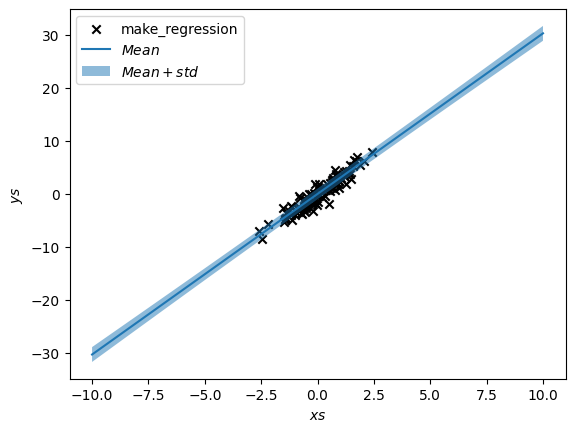

In [42]:
plt.scatter(xs, ys, marker='x', c='k', label='make_regression')
plt.plot(grid, means.ravel(), label='$Mean$')
plt.fill_between(grid, means.ravel()+np.sqrt(vars), means.ravel()-np.sqrt(vars), alpha=0.5, label='$Mean+std$')
plt.xlabel('$xs$')
plt.ylabel('$ys$')
plt.legend()
plt.show()

__Задание (1 балл).__ Посмотроим аналогичную иллюстрацию для линейной регрессии на полиномиальных признаках. Пример такой иллюстрации был дан в лекции:
![правая иллюстрация, слайд 51](https://github.com/ftad/BM2020/raw/master/materials/blr_illustrate_poly.png)

Используем xs из предыдущего задания и зададим ys, используя кубическую функцию. Будем обучать линейную регрессию на признаках $x, x^2, x^3, x^4$. "Загаданная" функция кубическая, поэтому веса при первом, втором и четвертом признаках должны получиться близкими к 0 - проверьте это! Не забудьте подписать оси!

Чтобы увидеть большие дисперсии по краям, может потребоваться немного подвинуть левую и правую границы сетки grid.

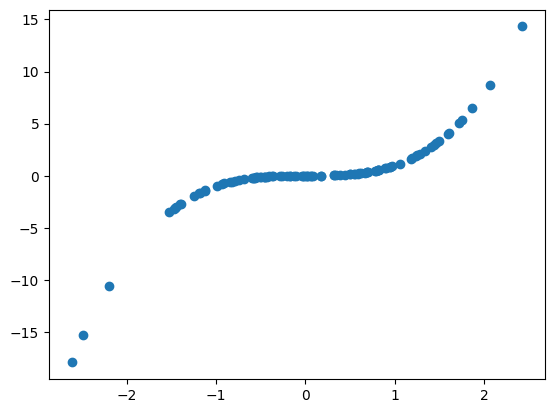

In [43]:
# Используем xs из предыдущего задания, а ys задаем, используя кубическюу фунцкию
ys = (xs**3).ravel()
plt.scatter(xs, ys)

In [45]:
blinreg = BayesianLinearRegression()
blinreg.fit(
    np.stack((xs.ravel(), (xs**2).ravel(), (xs**3).ravel(), (xs**4).ravel())).T,
    ys
)

In [46]:
grid = np.linspace(-5, 4, 1000)
means, vars = blinreg.predict(
    np.stack((grid.ravel(), (grid**2).ravel(), (grid**3).ravel(), (grid**4).ravel())).T
)

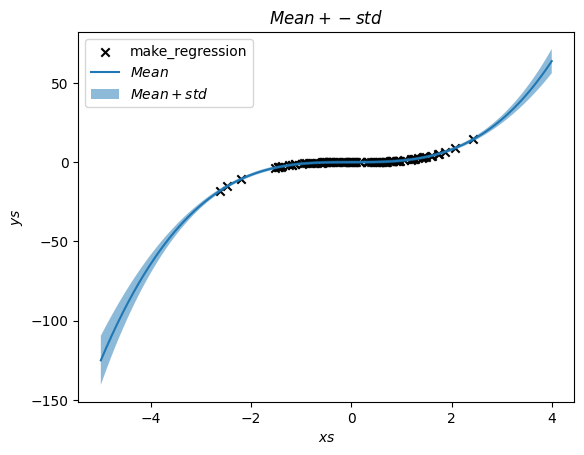

In [51]:
plt.scatter(xs, ys, marker='x', c='k', label='make_regression')
plt.plot(grid, means.ravel(), label='$Mean$')
plt.fill_between(grid, means.ravel()+np.sqrt(vars), means.ravel()-np.sqrt(vars), alpha=0.5, label='$Mean+std$')
plt.xlabel('$xs$')
plt.ylabel('$ys$')
plt.title('$Mean+-std$')
plt.legend()
plt.show()

В задании мы визуализировали дисперсии, предсказываемые байесовской линейной регрессией, и увидели, что они могут быть полезны для оценивания, принадлежит ли тестовый объект к общей совокупности данных или является объектом вне распределения (out-of-distribution).